# Classification binaire appliquée à la détection de cancer du sein

Ce notebook contient :
- Visualisation des données
- Préparation des données
- Entraînement & évaluation de modèles
    - Arbre de décision
    - Réseau de neurones

[Description du dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

[Exemples de tumeurs bénignes et malignes](https://www.semanticscholar.org/paper/Classifying-breast-cancer-types-based-on-fine-data-Ahmad-Yusoff/60e88562a14a03e7c9be580f965180f4c9b83d08/figure/0)

## Visualisation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import (
    preprocessing,
    model_selection,
    pipeline,
    compose,
    metrics,
    tree,
    neural_network
)

In [3]:
df_raw = (
    pd.read_csv("../data/breast-cancer.csv", sep=',')
    .drop(columns=["id"])
)

In [ ]:
df_raw.head()

Plusieurs fonctions et attributs peuvent être appelés à partir de l'objet `DataFrame` :
*   ``columns``
*   ``index``
*   ``sample``
*   ``tail()``

Utilisez-les pour obtenir des premières informations sur le dataset

In [ ]:
df_raw.columns

In [ ]:
df_raw.index

In [ ]:
df_raw.tail()

In [ ]:
df_raw.sample(5)

Maintenant regardons si le jeu de données contient des valeurs nulles. Utilisez la fonction ``isnull``

In [ ]:
df_raw.isnull().sum()

Affichons maintenant le schéma du dataframe

In [ ]:
df_raw.dtypes

In [ ]:
df_raw.info(memory_usage="deep")

La fonction describe permet d'afficher des statistiques

In [ ]:
df_raw.describe().T.round(3).style.background_gradient()

Maintenant utilisez différents graphes pour explorer les données (distributions, boxplots, pairplot,...)

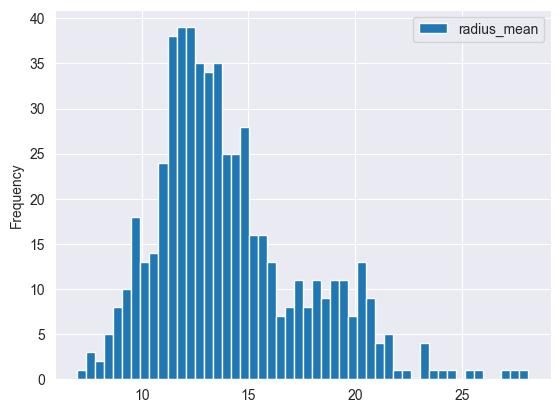

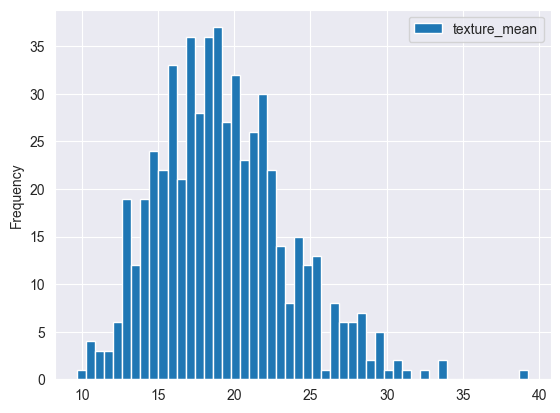

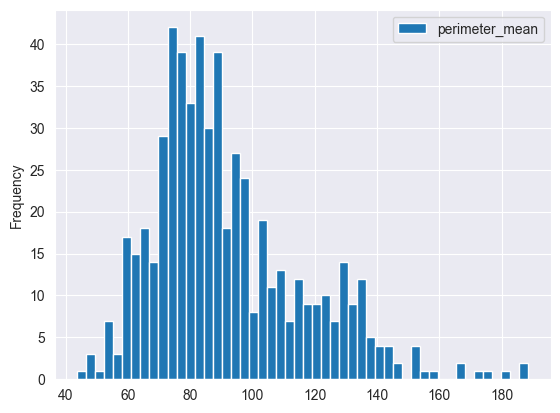

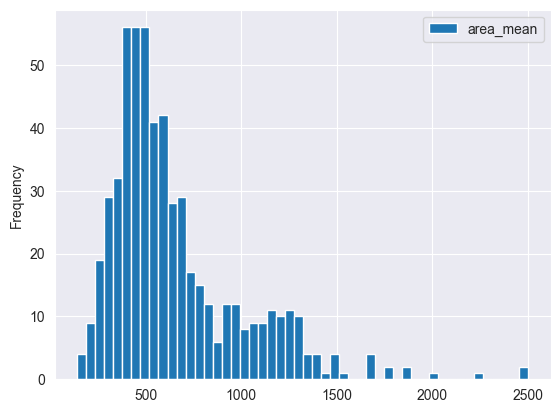

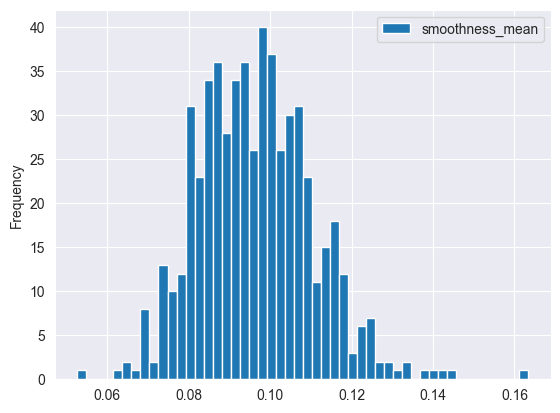

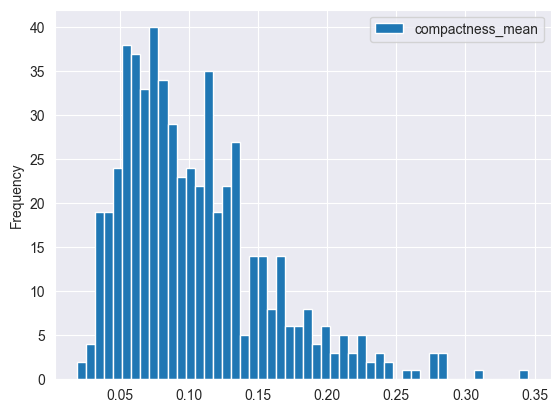

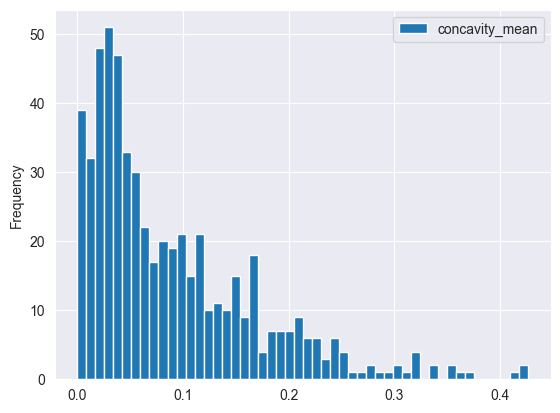

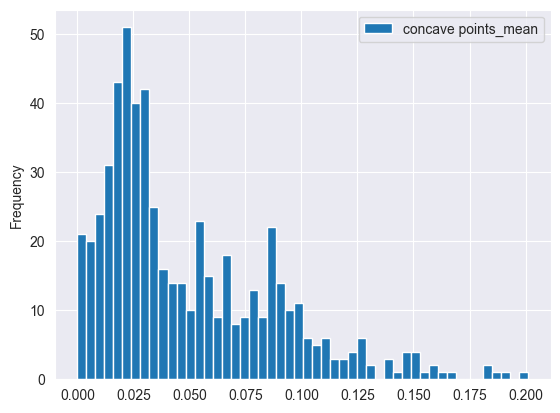

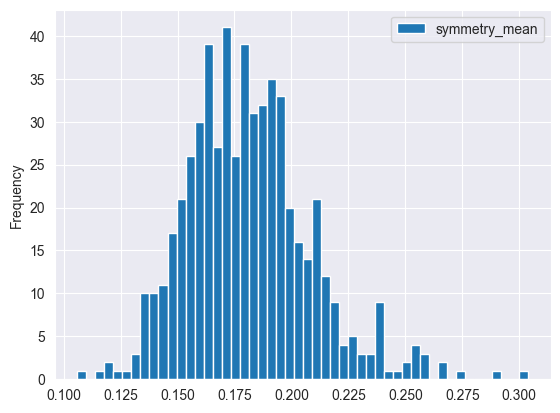

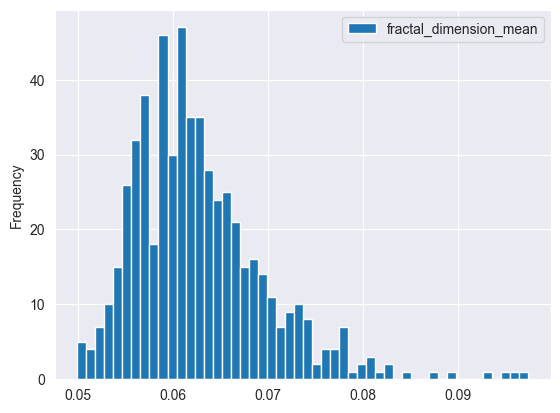

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10d5eca10>>
Traceback (most recent call last):
  File "/Users/lpreaux/projects/2024D10-intro-ia/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [5]:
num_cols = [col for col in df_raw.columns if col !="diagnosis"]

for col in num_cols:
    df_raw[[col]].plot.hist(bins=50)
    plt.show()

<Axes: >

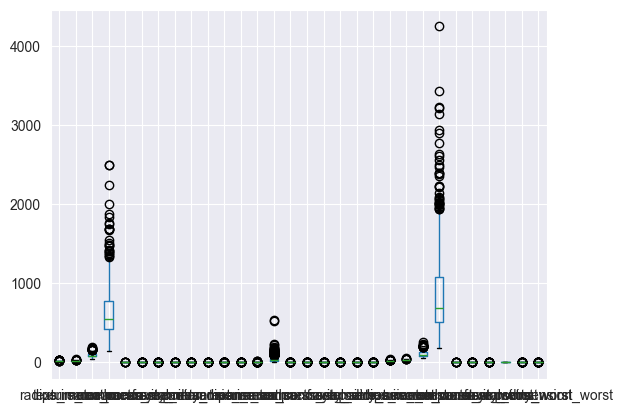

In [4]:
(
    df_raw
    .boxplot()
)

In [ ]:
df_raw["diagnosis"].value_counts().plot.bar()

In [ ]:
(
    df_raw["diagnosis"]
    .value_counts(
        normalize=True
    )
)

In [ ]:
pairplot_cols = num_cols[:10]
pairplot_cols.append("diagnosis")

sns.pairplot(df_raw[pairplot_cols], hue="diagnosis")

In [ ]:
corr = df_raw.drop("diagnosis", axis=1).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Préparation des données

### Préparation de la target

In [ ]:
df_raw["diagnosis"] = (
    df_raw["diagnosis"]
    .map({'M': 1, 'B':0})
)

### Division du jeu de données

In [ ]:
target = ["diagnosis"]
features = [col for col in df_raw.columns if col not in target]

X_train, X_test, y_train, y_test = (
    model_selection.train_test_split(
        df_raw[features],
        df_raw[target],
        test_size=0.15,
        random_state=42
    )
)

In [ ]:
y_train["diagnosis"].value_counts(normalize=True)

### Feature Engineering

#### Outliers

In [ ]:
X_train = (
    X_train
    # .loc[lambda df: df["symmetry_worst"]<0.6]
    # .loc[lambda df: df["concavity_worst"]<1]
)

y_train = (
    y_train
    # .loc[X_train.index]
)

#### Sélection de features

In [ ]:
features_to_remove = [
    "perimeter_mean",
    "area_mean",
    "perimeter_se",
    "area_se",
    "perimeter_worst",
    "area_worst"
]

selected_features = [col for col in X_train.columns if col not in features_to_remove]

feature_selection = compose.ColumnTransformer(transformers=[
        ('select', 'passthrough', selected_features),
    ])

In [ ]:
(
    pd.DataFrame(
        feature_selection.fit_transform(X_train),
        columns=selected_features
    )
)

#### Normalisation des features

In [ ]:
pipe = pipeline.Pipeline([
    ("feature_selection", feature_selection),
    ('std_scaler', preprocessing.StandardScaler())]
)

In [ ]:
(
    pd.DataFrame(
        pipe.fit_transform(X_train),
        columns=selected_features
    )
)

## Entraînement d'un arbre de décision

In [ ]:
pipe = pipeline.Pipeline([
    # ("feature_selection", feature_selection),
    # ('std_scaler', preprocessing.StandardScaler()),
    ('decision_tree', tree.DecisionTreeClassifier())]
)

In [ ]:
pipe.fit(X_train, y_train)

## Evaluation

L'arbre de décision est maintenant entraîné.
Pour mesurer sa performance, vous pouvez calculer son **accuracy**.

Sklearn fournit également la fonction ``plot_tree`` qui permet d'afficher la structure de l'arbre.

In [ ]:
print("Accuracy on train set =", pipe.score(X_train,y_train))
print("Accuracy on test set =", pipe.score(X_test,y_test))

In [ ]:
plt.figure(figsize=(30,20))
tree.plot_tree(
    pipe[-1],
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    class_names=["B","M"],
    fontsize=9
)
plt.savefig("tree_raw.png",bbox_inches="tight")

La **matrice de confusion** donne plus d'information sur les forces et les faiblesses du modèle.

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, pipe.predict(X_test), cmap="Blues")

Sklearn fournit également un rapport de classification avec de nombreuses métriques calculées.

In [ ]:
print(metrics.classification_report(y_train, pipe.predict(X_train)))

In [ ]:
print(metrics.classification_report(y_test, pipe.predict(X_test)))

Nous avons entraîné un arbre de décision avec ses paramètres par défaut: Il n'y a pas de containte sur la **profondeur** de l'arbre

Modifions quelques paramètres pour voir leur influence :
- `max_depth`
- `max_lead_nodes`

In [ ]:
pipe = pipeline.Pipeline([
    ("feature_selection", feature_selection),
    ('std_scaler', preprocessing.StandardScaler()),
    (
        'decision_tree',
        tree.DecisionTreeClassifier(
            max_depth=3,
            max_leaf_nodes=5
        )
    )]
)

pipe.fit(X_train, y_train)

In [ ]:
print("Accuracy on train set =", pipe.score(X_train,y_train))
print("Accuracy on test set =", pipe.score(X_test,y_test))

metrics.ConfusionMatrixDisplay.from_predictions(y_test, pipe.predict(X_test), cmap="Blues")

In [ ]:
plt.figure(figsize=(30,20))
tree.plot_tree(
    pipe[-1],
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    class_names=["B","M"],
    fontsize=18
)
plt.savefig("tree_hp.png",bbox_inches="tight")

In [ ]:
print(metrics.classification_report(y_train, pipe.predict(X_train)))

In [ ]:
print(metrics.classification_report(y_test, pipe.predict(X_test)))

In [ ]:
precision, recall, threshold = (
    metrics.precision_recall_curve(
        y_test,
        pipe.predict_proba(X_test)[:,1]
    )
)

plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Tradeoff')
plt.show()

### Réseau de neurones

In [ ]:
pipe = pipeline.Pipeline([
    ("feature_selection", feature_selection),
    ('std_scaler', preprocessing.StandardScaler()),
    ('neural_network', neural_network.MLPClassifier())]
)

pipe.fit(X_train, y_train)

In [ ]:
print("Accuracy on train set =", pipe.score(X_train,y_train))
print("Accuracy on test set =", pipe.score(X_test,y_test))

metrics.ConfusionMatrixDisplay.from_predictions(y_test, pipe.predict(X_test), cmap="Blues")

In [ ]:
print(metrics.classification_report(y_train, pipe.predict(X_train)))

In [ ]:
print(metrics.classification_report(y_test, pipe.predict(X_test)))

In [ ]:
precision, recall, threshold = (
    metrics.precision_recall_curve(
        y_test,
        pipe.predict_proba(X_test)[:,1]
    )
)

plt.plot(recall,precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Tradeoff')
plt.show()